In [1]:
import torch
import numpy as np
import json
import os
import argparse

from utils.datasets import WSIData
from torch.utils.data import DataLoader
from utils.train_dsmil import train_dsmil_model
from utils.test_dsmil import test_dsmil_model
from models.dsmil import MILNet, FCLayer, BClassifier

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../utils')
from S3FileManager import S3FileManager

bucket_name = 'oncodata-sagemaker-shared/roraima/features/stomach/Stomach_feats_mocov3/v1/'
local_dir = '/tmp/train-data'

file_manager = S3FileManager(bucket_name=bucket_name, local_dir=local_dir)

In [3]:
ls *.json

stomach_json.json  stomach_json_test.json  stomach_json_train.json


In [4]:
# print the current pytorch and python versions
print(torch.__version__)
print(sys.version)


2.0.0.post101
3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]


In [5]:
FEATURES_FOLDER = r'/tmp/train-data'
FEATS_SIZE = 256
NUM_CLASSES = 1
NUM_EPOCHS = 50
TASK = 'stomach_urg'
lr = 5e-3
weight_decay = 1e-4
CLASSES = ['Primary Tumor', 'Solid Tissue Normal']
OVERSAMPLE_MINORITY = True
STAGES_FILES = {'train': 'stomach_json_train.json'}  #{'train': 'prostate_json_train.json', 'val': 'prostate_json_test.json'}
USE_VALIDATION = len(STAGES_FILES.keys()) > 1
TEST_FILE = 'stomach_json_test.json'

In [6]:
loader = {}
for stage in STAGES_FILES.keys():
    dataset = WSIData(features_dir=FEATURES_FOLDER, stage=stage, task=TASK, json_name=STAGES_FILES[stage],
                      classes_to_use=CLASSES, oversample_minority=OVERSAMPLE_MINORITY)
    data_loader = DataLoader(dataset, batch_size=1, num_workers=0, shuffle=True)
    loader.update({stage: data_loader})

Counts prior oversample {'Primary Tumor': 306, 'Solid Tissue Normal': 60}
After oversample {'Primary Tumor': 306, 'Solid Tissue Normal': 300}


In [7]:
USE_VALIDATION

False

In [8]:
def load_dsmil(feats_size, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    i_classifier = FCLayer(in_size=feats_size, out_size=num_classes).to(device)
    b_classifier = BClassifier(input_size=feats_size, output_class=num_classes, dropout_v = 0., nonlinear = 1).to(device)
    return MILNet(i_classifier, b_classifier).to(device)

In [9]:
model = load_dsmil(FEATS_SIZE, NUM_CLASSES)

In [10]:
train_dsmil_model(model, loader, num_runs=1, lr=lr, weight_decay=weight_decay, num_epochs=NUM_EPOCHS,
                  num_classes=NUM_CLASSES, feats_size=FEATS_SIZE, use_validation=USE_VALIDATION)

  0%|          | 0/1 [00:00<?, ?it/s]

Experiment 1/1



100%|██████████| 1/1 [00:52<00:00, 52.51s/it]

 Epoch [1/1]  train loss: 0.2963, val loss: -1.0000, average score: -1.0000, auc: -1.0000
AUC 0.0 Best Epoch -1 Seed: 7101 Threshold:  -1


In [11]:
model

MILNet(
  (i_classifier): FCLayer(
    (fc): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (b_classifier): BClassifier(
    (q): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
    )
    (v): Identity()
    (fcc): Conv1d(1, 1, kernel_size=(256,), stride=(1,))
  )
)

In [11]:
test_dataset = WSIData(features_dir=FEATURES_FOLDER, stage='test', task=TASK, json_name=TEST_FILE,
                       classes_to_use=CLASSES, oversample_minority=False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=True)
auc_value, test_labels, test_predictions = test_dsmil_model(model, test_loader, feats_size=256, num_classes=1)

In [12]:
print(auc_value)

0.9868491680085882


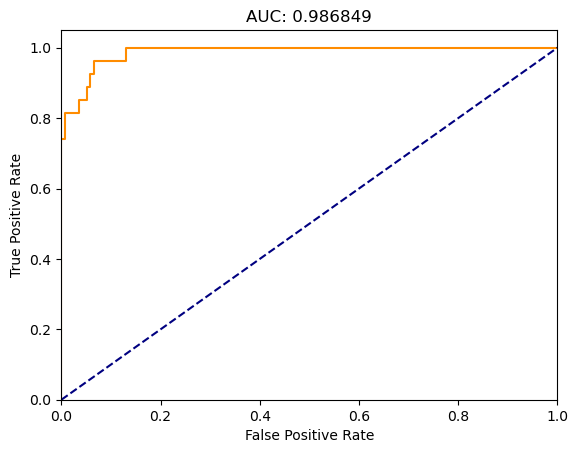

In [13]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
plt.figure()
plt.plot(fpr, tpr, color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('AUC: %f' % (auc_value))
plt.savefig('roc_stomach.png', dpi=300)
plt.show()

In [15]:
cm = confusion_matrix(test_labels, [x > 0.5 for x in test_predictions])
print(cm)

[[133   5]
 [  0  27]]


In [16]:
sensibility = cm[0,0]/(cm[0,0] + cm[0,1])
specificity = cm[1,1]/(cm[1,1] + cm[1,0])

print(TASK)
print('Specibility', specificity)
print('Sensibility', sensibility)

stomach_urg
Specibility 1.0
Sensibility 0.9637681159420289


In [18]:
27/(27 + 8)

0.7714285714285715

In [17]:
26/(26 + 1)

0.9629629629629629